**The paradigm behind DL is now facing a shift from model-centric to data-centric.**

- See how data intricacies affect outcome of your models. 
- To show how far it will take to apply data changes without addressing model
    - use a single model throughout: a simple CNN.
    
- While training this model journey will take to address common problems: 
    - class imbalance
    - overfitting
    
- Walk through useful diagnosis tools & methods to mitigate these common problems.

In [ ]:
import os
import shutil
import random
import zipfile
import tarfile
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

# To ignore some warnings about Image metadata that Pillow prints out
import warnings
warnings.filterwarnings("ignore")

Before you move on, download two datasets used in lab, as well as pretrained models & histories:

In [ ]:
# Download datasets

# Cats & dogs
!wget https://storage.googleapis.com/mlep-public/course_1/week2/kagglecatsanddogs_3367a.zip

# Caltech birds
!wget https://storage.googleapis.com/mlep-public/course_1/week2/CUB_200_2011.tar

# Download pretrained models & training histories
!wget -q -P /content/model-balanced/ https://storage.googleapis.com/mlep-public/course_1/week2/model-balanced/saved_model.pb
!wget -q -P /content/model-balanced/variables/ https://storage.googleapis.com/mlep-public/course_1/week2/model-balanced/variables/variables.data-00000-of-00001
!wget -q -P /content/model-balanced/variables/ https://storage.googleapis.com/mlep-public/course_1/week2/model-balanced/variables/variables.index
!wget -q -P /content/history-balanced/ https://storage.googleapis.com/mlep-public/course_1/week2/history-balanced/history-balanced.csv

!wget -q -P /content/model-imbalanced/ https://storage.googleapis.com/mlep-public/course_1/week2/model-imbalanced/saved_model.pb
!wget -q -P /content/model-imbalanced/variables/ https://storage.googleapis.com/mlep-public/course_1/week2/model-imbalanced/variables/variables.data-00000-of-00001
!wget -q -P /content/model-imbalanced/variables/ https://storage.googleapis.com/mlep-public/course_1/week2/model-imbalanced/variables/variables.index
!wget -q -P /content/history-imbalanced/ https://storage.googleapis.com/mlep-public/course_1/week2/history-imbalanced/history-imbalanced.csv

!wget -q -P /content/model-augmented/ https://storage.googleapis.com/mlep-public/course_1/week2/model-augmented/saved_model.pb
!wget -q -P /content/model-augmented/variables/ https://storage.googleapis.com/mlep-public/course_1/week2/model-augmented/variables/variables.data-00000-of-00001
!wget -q -P /content/model-augmented/variables/ https://storage.googleapis.com/mlep-public/course_1/week2/model-augmented/variables/variables.index
!wget -q -P /content/history-augmented/ https://storage.googleapis.com/mlep-public/course_1/week2/history-augmented/history-augmented.csv

## Combining datasets

The raw images in these datasets can be found within following paths:


In [ ]:
cats_and_dogs_zip = '/content/kagglecatsanddogs_3367a.zip'
caltech_birds_tar = '/content/CUB_200_2011.tar'

base_dir = '/tmp/data'

Extracting data into `base_dir` in this case.

Note that `cats vs dogs` images are in `zip` file format while `caltech birds` images come in a `tar` file.

In [ ]:
with zipfile.ZipFile(cats_and_dogs_zip, 'r') as my_zip:
  my_zip.extractall(base_dir)

In [ ]:
with tarfile.open(caltech_birds_tar, 'r') as my_tar:
  my_tar.extractall(base_dir)

For cats & dogs images no further preprocessing is needed as all exemplars of a single class are located in one directory: `PetImages\Cat` & `PetImages\Dog` respectively.

In [ ]:
base_dogs_dir = os.path.join(base_dir, 'PetImages/Dog')
base_cats_dir = os.path.join(base_dir,'PetImages/Cat')

print(f"There are {len(os.listdir(base_dogs_dir))} images of dogs")
print(f"There are {len(os.listdir(base_cats_dir))} images of cats")

There are 12501 images of dogs
There are 12501 images of cats


Bird images dataset used to classify species of birds so there is a directory for each species.
- Move all bird images to a single directory (`PetImages/Bird`)

In [ ]:
raw_birds_dir = '/tmp/data/CUB_200_2011/images'
base_birds_dir = os.path.join(base_dir,'PetImages/Bird')
os.mkdir(base_birds_dir)

for subdir in os.listdir(raw_birds_dir):
  subdir_path = os.path.join(raw_birds_dir, subdir)
  for image in os.listdir(subdir_path):
    shutil.move(os.path.join(subdir_path, image), os.path.join(base_birds_dir))

print(f"There are {len(os.listdir(base_birds_dir))} images of birds")

There are 11788 images of birds


It turns out that there is a similar number of images for each class you are trying to predict! Nice!

Sample cat image:


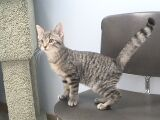


Sample dog image:


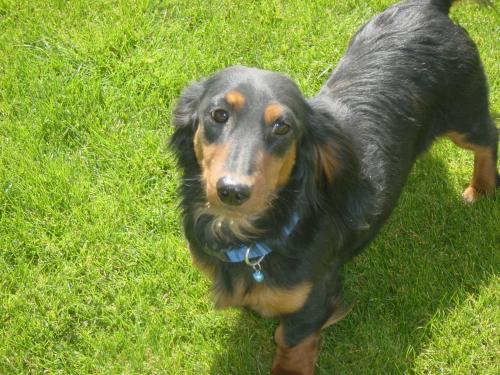


Sample bird image:


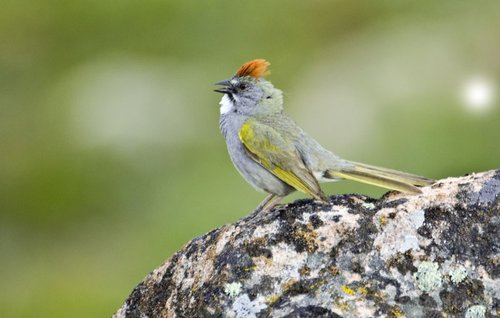

In [ ]:
from IPython.display import Image, display

print("Sample cat image:")
display(Image(filename=f"{os.path.join(base_cats_dir, os.listdir(base_cats_dir)[0])}"))
print("\nSample dog image:")
display(Image(filename=f"{os.path.join(base_dogs_dir, os.listdir(base_dogs_dir)[0])}"))
print("\nSample bird image:")
display(Image(filename=f"{os.path.join(base_birds_dir, os.listdir(base_birds_dir)[0])}"))

## Train / Evaluate Split

In [ ]:
train_eval_dirs = ['train/cats', 'train/dogs', 'train/birds',
                   'eval/cats', 'eval/dogs', 'eval/birds']

for dir in train_eval_dirs:
  if not os.path.exists(os.path.join(base_dir, dir)):
    os.makedirs(os.path.join(base_dir, dir))

Move a percentage of images from an origin folder to a destination folder as desired to generate training & evaluation splits

In [ ]:
def move_to_destination(origin, destination, percentage_split):
  num_images = int(len(os.listdir(origin))*percentage_split)
  for image_name, image_number in zip(sorted(os.listdir(origin)), range(num_images)):
    shutil.move(os.path.join(origin, image_name), destination)

And now you are ready to call previous function & split data:

In [ ]:
# Move 70% of images to train dir
move_to_destination(base_cats_dir, os.path.join(base_dir, 'train/cats'), 0.7)
move_to_destination(base_dogs_dir, os.path.join(base_dir, 'train/dogs'), 0.7)
move_to_destination(base_birds_dir, os.path.join(base_dir, 'train/birds'), 0.7)


# Move remaining images to eval dir
move_to_destination(base_cats_dir, os.path.join(base_dir, 'eval/cats'), 1)
move_to_destination(base_dogs_dir, os.path.join(base_dir, 'eval/dogs'), 1)
move_to_destination(base_birds_dir, os.path.join(base_dir, 'eval/birds'), 1)

Dataset has some issues that will prevent model training & evaluation
1. Some images are corrupted & have zero bytes.
2. Cats vs dogs zip file included a `.db` file for each class that needs to be deleted.

If you didn't fix this before training, errors regarding these issues & training will fail.
- Zero-byte images are not valid images & Keras will let you know once these files are reached.
- `.db` files are not valid images. 

**Make sure that you are submitting files with correct specifications to your training algorithm before start running it** as these issues might not be encountered right away & you will have to solve them & start training again.

Running following `bash` commands in base directory will resolve these issues:

In [ ]:
!find /tmp/data/ -size 0 -exec rm {} +
# removes all zero-byte files
!find /tmp/data/ -type f ! -name "*.jpg" -exec rm {} +
# removes any file that does not have a `.jpg` extension

After remove corrupted images

In [ ]:
print(f"There are {len(os.listdir(os.path.join(base_dir, 'train/cats')))} images of cats for training")
print(f"There are {len(os.listdir(os.path.join(base_dir, 'train/dogs')))} images of dogs for training")
print(f"There are {len(os.listdir(os.path.join(base_dir, 'train/birds')))} images of birds for training\n")

print(f"There are {len(os.listdir(os.path.join(base_dir, 'eval/cats')))} images of cats for evaluation")
print(f"There are {len(os.listdir(os.path.join(base_dir, 'eval/dogs')))} images of dogs for evaluation")
print(f"There are {len(os.listdir(os.path.join(base_dir, 'eval/birds')))} images of birds for evaluation")

There are 8750 images of cats for training
There are 8749 images of dogs for training
There are 8251 images of birds for training

There are 3749 images of cats for evaluation
There are 3750 images of dogs for evaluation
There are 3537 images of birds for evaluation


## An unexpected issue!

There was a power outage, only 20% of dog images & 10% of bird images survived.

Create a new directory called `imbalanced` & copy only proportions mentioned above for each class.

In [ ]:
for dir in train_eval_dirs:
  if not os.path.exists(os.path.join(base_dir, 'imbalanced/'+dir)):
    os.makedirs(os.path.join(base_dir, 'imbalanced/'+dir))

In [ ]:
# Very similar to one used before but this one copies instead of moving
def copy_with_limit(origin, destination, percentage_split):
  num_images = int(len(os.listdir(origin))*percentage_split)
  for image_name, image_number in zip(sorted(os.listdir(origin)), range(num_images)):
    shutil.copy(os.path.join(origin, image_name), destination)

# Perform copying
copy_with_limit(os.path.join(base_dir, 'train/cats'), os.path.join(base_dir, 'imbalanced/train/cats'), 1)
copy_with_limit(os.path.join(base_dir, 'train/dogs'), os.path.join(base_dir, 'imbalanced/train/dogs'), 0.2)
copy_with_limit(os.path.join(base_dir, 'train/birds'), os.path.join(base_dir, 'imbalanced/train/birds'), 0.1)

copy_with_limit(os.path.join(base_dir, 'eval/cats'), os.path.join(base_dir, 'imbalanced/eval/cats'), 1)
copy_with_limit(os.path.join(base_dir, 'eval/dogs'), os.path.join(base_dir, 'imbalanced/eval/dogs'), 0.2)
copy_with_limit(os.path.join(base_dir, 'eval/birds'), os.path.join(base_dir, 'imbalanced/eval/birds'), 0.1)

# Print number of available images
print(f"There are {len(os.listdir(os.path.join(base_dir, 'imbalanced/train/cats')))} images of cats for training")
print(f"There are {len(os.listdir(os.path.join(base_dir, 'imbalanced/train/dogs')))} images of dogs for training")
print(f"There are {len(os.listdir(os.path.join(base_dir, 'imbalanced/train/birds')))} images of birds for training\n")

print(f"There are {len(os.listdir(os.path.join(base_dir, 'imbalanced/eval/cats')))} images of cats for evaluation")
print(f"There are {len(os.listdir(os.path.join(base_dir, 'imbalanced/eval/dogs')))} images of dogs for evaluation")
print(f"There are {len(os.listdir(os.path.join(base_dir, 'imbalanced/eval/birds')))} images of birds for evaluation")

There are 8750 images of cats for training
There are 1749 images of dogs for training
There are 825 images of birds for training

There are 3749 images of cats for evaluation
There are 750 images of dogs for evaluation
There are 353 images of birds for evaluation


## Selecting model

Create a model architecture & define a loss function, optimizer & performance metrics leveraging keras API

In [ ]:
from tensorflow.keras import layers, models, optimizers

def create_model():
  # A simple CNN architecture based on one found here: https://www.tensorflow.org/tutorials/images/classification
  model = models.Sequential([
  layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(128, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(3, activation='softmax')
  ])


  # Compile model
  model.compile(
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      optimizer=optimizers.Adam(),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
  )

  return model

In [ ]:
# Create a model to use with imbalanced dataset
imbalanced_model = create_model()

# Print model's summary
print(imbalanced_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

For training, use ImageDataGenerator, which has built-in functionalities to easily feed with raw, rescaled or even augmented image data.

- `flow_from_directory` method allows to read images as needed from a root directory. Arguments:
    - `directory`: Path to root directory where images are stored.
    - `target_size`: dimensions to which all images found will be resized. Since images come in all kinds of resolutions, you need to standardize their size. 150x150 is used but other values should work well too.
    - `batch_size`: Number of images generator yields everytime it is asked for a next batch. 32 is used here.
    - `class_mode`: How labels are represented. Here "binary" is used to indicate that labels will be 1D. This is done for compatibility with loss & evaluation metrics used when compiling model.

[tutorial](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# No data augmentation for now, only normalizing pixel values
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Point to imbalanced directory
train_generator = train_datagen.flow_from_directory(
        '/tmp/data/imbalanced/train',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        '/tmp/data/imbalanced/eval',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

Found 11324 images belonging to 3 classes.
Found 4852 images belonging to 3 classes.


Quick sanity check to inspect both generators (training & validation) use same labels for each class

In [ ]:
print(f"labels for each class in train generator are: {train_generator.class_indices}")
print(f"labels for each class in validation generator are: {validation_generator.class_indices}")

labels for each class in the train generator are: {'birds': 0, 'cats': 1, 'dogs': 2}
labels for each class in the validation generator are: {'birds': 0, 'cats': 1, 'dogs': 2}



# Training a CNN with class imbalanced data


In [ ]:
# Load pretrained model & history

imbalanced_history = pd.read_csv('history-imbalanced/history-imbalanced.csv')
imbalanced_model = tf.keras.models.load_model('model-imbalanced')

In [ ]:
# Run only if you want to train model yourself (this takes around 20 mins with GPU enabled)

# imbalanced_history = imbalanced_model.fit(
#     train_generator,
#     steps_per_epoch=100,
#     epochs=50,
#     validation_data=validation_generator,
#     validation_steps=80)

To analyze model performance properly, it is important to track different metrics such as accuracy & loss function along training process. Let's define a helper function to handle metrics through training history,depending on method you previously selected:

In [ ]:
def get_training_metrics(history):
  
  # This is needed depending on if you used pretrained model or you trained it yourself
  if not isinstance(history, pd.core.frame.DataFrame):
    history = history.history
  
  acc = history['sparse_categorical_accuracy']
  val_acc = history['val_sparse_categorical_accuracy']

  loss = history['loss']
  val_loss = history['val_loss']

  return acc, val_acc, loss, val_loss

Now, let's plot metrics & losses for each training epoch as training process progresses. 

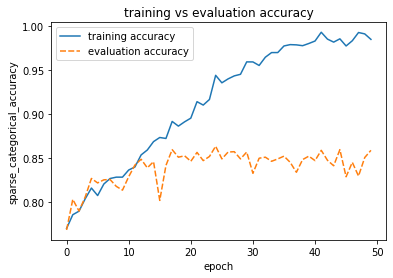

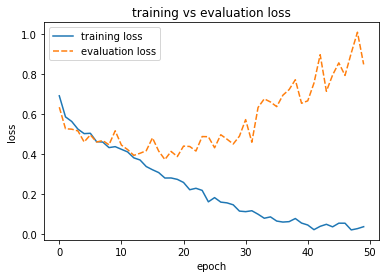

In [ ]:
def plot_train_eval(history):
  acc, val_acc, loss, val_loss = get_training_metrics(history)

  acc_plot = pd.DataFrame({"training accuracy":acc, "evaluation accuracy":val_acc})
  acc_plot = sns.lineplot(data=acc_plot)
  acc_plot.set_title('training vs evaluation accuracy')
  acc_plot.set_xlabel('epoch')
  acc_plot.set_ylabel('sparse_categorical_accuracy')
  plt.show()

  print("")

  loss_plot = pd.DataFrame({"training loss":loss, "evaluation loss":val_loss})
  loss_plot = sns.lineplot(data=loss_plot)
  loss_plot.set_title('training vs evaluation loss')
  loss_plot.set_xlabel('epoch')
  loss_plot.set_ylabel('loss')
  plt.show()

plot_train_eval(imbalanced_history)

Overfit training data.

However, evaluation accuracy is still pretty high. Maybe class imbalance is not such a big issue after all. Perhaps this is too good to be true. 

Compare: accuracy score,  accuracy score balanced, & confusion matrix.
- [sklearn](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics) documentation

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, balanced_accuracy_score

In [ ]:
# Use validation generator without shuffle to easily compute additional metrics
val_gen_no_shuffle = test_datagen.flow_from_directory(
    '/tmp/data/imbalanced/eval',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False)

Found 4852 images belonging to 3 classes.


In [ ]:
# Get true labels from generator
y_true = val_gen_no_shuffle.classes

# Use model to predict (will take a couple of minutes)
predictions_imbalanced = imbalanced_model.predict(val_gen_no_shuffle)

# Get argmax (since softmax is being used)
y_pred_imbalanced = np.argmax(predictions_imbalanced, axis=1)

# Print accuracy score
print(f"Accuracy Score: {accuracy_score(y_true, y_pred_imbalanced)}")

# Print balanced accuracy score
print(f"Balanced Accuracy Score: {balanced_accuracy_score(y_true, y_pred_imbalanced)}")

Accuracy Score: 0.855111294311624
Balanced Accuracy Score: 0.7417486453422518


Comparing `accuracy` & `balanced accuracy` metrics, class imbalance starts to become apparent. 

`confusion matrix` of predictions.

Class imbalance is also present in evaluation set so confusion matrix will show an overwhelming majority for cats.

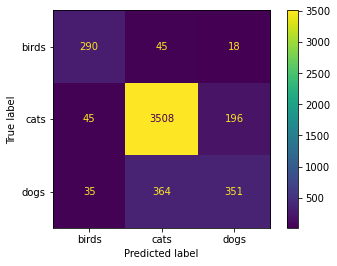

In [ ]:
imbalanced_cm = confusion_matrix(y_true, y_pred_imbalanced)
ConfusionMatrixDisplay(imbalanced_cm, display_labels=['birds', 'cats', 'dogs']).plot(values_format="d")

In [ ]:
misclassified_birds = (imbalanced_cm[1,0] + imbalanced_cm[2,0])/np.sum(imbalanced_cm, axis=0)[0]
misclassified_cats = (imbalanced_cm[0,1] + imbalanced_cm[2,1])/np.sum(imbalanced_cm, axis=0)[1]
misclassified_dogs = (imbalanced_cm[0,2] + imbalanced_cm[1,2])/np.sum(imbalanced_cm, axis=0)[2]

print(f"Proportion of misclassified birds: {misclassified_birds*100:.2f}%")
print(f"Proportion of misclassified cats: {misclassified_cats*100:.2f}%")
print(f"Proportion of misclassified dogs: {misclassified_dogs*100:.2f}%")

Proportion of misclassified birds: 21.62%
Proportion of misclassified cats: 10.44%
Proportion of misclassified dogs: 37.88%


Class imbalance is a real problem that if not detected early on, gives wrong impression that your model is performing better than it actually is. 

**In this case standard `accuracy` metric is misleading** & provides a false sense that model is performing better than it actually is.

To prove this point further consider a model that only predicts cats:

In [ ]:
# Predict cat for all images
all_cats = np.ones(y_true.shape)

# Print accuracy score
print(f"Accuracy Score: {accuracy_score(y_true, all_cats)}")

# Print balanced accuracy score
print(f"Balanced Accuracy Score: {balanced_accuracy_score(y_true, all_cats)}")

Accuracy Score: 0.7726710634789777
Balanced Accuracy Score: 0.3333333333333333


If you only look at `accuracy` metric model seems to be working fairly well, since majority class is same that model always predicts.

There are several techniques to deal with class imbalance. A very popular one is `SMOTE`, which oversamples minority classes by creating syntethic data. However, these techniques are outside scope of this lab.

Previous metrics were computed with class imbalance both on training & evaluation sets. If you are wondering how model performed with class imbalance only on training set run following cell to see confusion matrix with balanced classes in evaluation set:


Found 11036 images belonging to 3 classes.


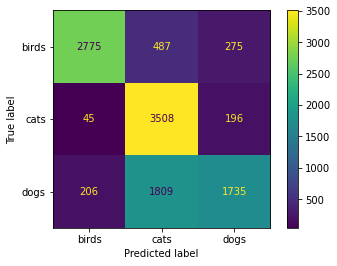

In [ ]:
# Use validation generator without shuffle to easily compute additional metrics
val_gen_no_shuffle = test_datagen.flow_from_directory(
    '/tmp/data/eval',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False)

# Get true labels from generator
y_true = val_gen_no_shuffle.classes

# Use model to predict (will take a couple of minutes)
predictions_imbalanced = imbalanced_model.predict(val_gen_no_shuffle)

# Get argmax (since softmax is being used)
y_pred_imbalanced = np.argmax(predictions_imbalanced, axis=1)

# Confusion matrix
imbalanced_cm = confusion_matrix(y_true, y_pred_imbalanced)
ConfusionMatrixDisplay(imbalanced_cm, display_labels=['birds', 'cats', 'dogs']).plot(values_format="d")

# Training with complete dataset

In [ ]:
# Create a model to use with balanced dataset
balanced_model = create_model()

In [ ]:
# Still no data augmentation, only re-scaling
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generators now point to complete dataset
train_generator = train_datagen.flow_from_directory(
        '/tmp/data/train',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        '/tmp/data/eval',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

Found 25750 images belonging to 3 classes.
Found 11036 images belonging to 3 classes.


In [ ]:
# Load pretrained model & history

balanced_history = pd.read_csv('history-balanced/history-balanced.csv')
balanced_model = tf.keras.models.load_model('model-balanced')

In [ ]:
# Run only if you want to train model yourself (this takes around 20 mins with GPU enabled)

# balanced_history = balanced_model.fit(
#     train_generator,
#     steps_per_epoch=100,
#     epochs=50,
#     validation_data=validation_generator,
#     validation_steps=80)

Let's check how `accuracy` vs `balanced accuracy` comparison looks like now:

In [ ]:
# Use validation generator without shuffle to easily compute additional metrics
val_gen_no_shuffle = test_datagen.flow_from_directory(
    '/tmp/data/eval',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False)

Found 11036 images belonging to 3 classes.


In [ ]:
# Get true labels from generator
y_true = val_gen_no_shuffle.classes

# Use model to predict (will take a couple of minutes)
predictions_balanced = balanced_model.predict(val_gen_no_shuffle)

# Get argmax (since softmax is being used)
y_pred_balanced = np.argmax(predictions_balanced, axis=1)

# Print accuracy score
print(f"Accuracy Score: {accuracy_score(y_true, y_pred_balanced)}")

# Print balanced accuracy score
print(f"Balanced Accuracy Score: {balanced_accuracy_score(y_true, y_pred_balanced)}")

Accuracy Score: 0.8636281261326567
Balanced Accuracy Score: 0.8647221799730266


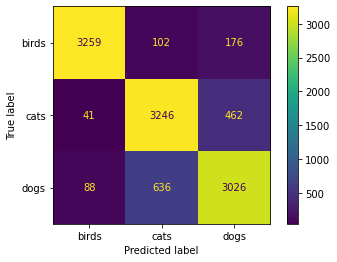

In [ ]:
balanced_cm = confusion_matrix(y_true, y_pred_balanced)
ConfusionMatrixDisplay(balanced_cm, display_labels=['birds', 'cats', 'dogs']).plot(values_format="d")

Both accuracy-based metrics are very similar now. confusion matrix also looks way better than before. 

Class imbalance has been successfully mitigated by adding more data to previously undersampled classes.

Now you can trust `accuracy` metric

Plot training history

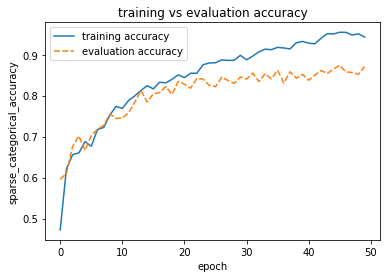

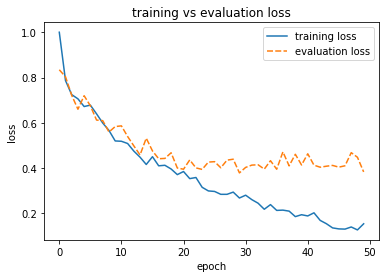

In [ ]:
plot_train_eval(balanced_history)

This looks much better than for imbalanced case! However, overfitting is still present.

Can you think of ways to address this issue? If you are familiar with CNN's you might think of adding `dropout` layers. This intuition is correct but for time being you decide to stick with same model & only change data to see if it is possible to mitigate overfitting in this manner.

Another possible solution is to apply data augmentation techniques. Your whole team agrees this is way to go so you decide to try this next!

# Training with Data Augmentation

Augmenting images is a technique in which you create new versions of images you have at hand, by applying geometric transformations. These transformations can vary from: zooming in & out, rotating, or even flipping images. By doing this, you get a training dataset that exposes model to a wider variety of images. This helps in further exploring feature space & hence reducing chances of overfitting. 

It is also a very natural idea since doing slight (or sometimes not so slight) changes to an image will result in an equally valid image. A cat sitting in an awkward position is still a cat, right?

In [ ]:
# Create a model to use with balanced & augmented dataset
augmented_model = create_model()

In [ ]:
# Now applying image augmentation
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=50,
        width_shift_range=0.15,
        height_shift_range=0.15,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)


test_datagen = ImageDataGenerator(rescale=1./255)

# Still pointing to directory with full dataset
train_generator = train_datagen.flow_from_directory(
        '/tmp/data/train',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        '/tmp/data/eval',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

Found 25750 images belonging to 3 classes.
Found 11036 images belonging to 3 classes.


Notice that only difference with previous training is that `ImageDataGenerator` object now has some extra parameters. 

Also **this was only done to training generator since this technique should only be applied to training images.**

Let's see these transformations in action. following cell applies & displays different transformations for a single image:


Transformation number: 0



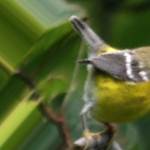


Transformation number: 1



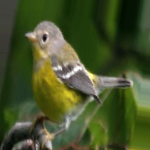


Transformation number: 2



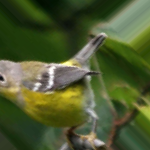


Transformation number: 3



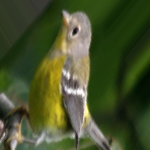

In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img, load_img


# Displays transformations on random images of birds in training partition
def display_transformations(gen):
  train_birds_dir = "/tmp/data/train/birds"
  random_index = random.randint(0, len(os.listdir(train_birds_dir)))
  sample_image = load_img(f"{os.path.join(train_birds_dir, os.listdir(train_birds_dir)[random_index])}", target_size=(150, 150))
  sample_array = img_to_array(sample_image)
  sample_array = sample_array[None, :]


  for iteration, array in zip(range(4), gen.flow(sample_array, batch_size=1)):
    array = np.squeeze(array)
    img = array_to_img(array)
    print(f"\nTransformation number: {iteration}\n")
    display(img)


# An example of an ImageDataGenerator
sample_gen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=50,
        width_shift_range=0.25,
        height_shift_range=0.25,
        shear_range=0.2,
        zoom_range=0.25,
        horizontal_flip=True)

display_transformations(sample_gen)


Transformation number: 0



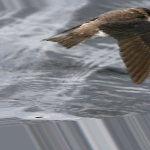


Transformation number: 1



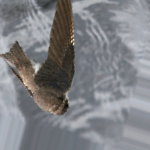


Transformation number: 2



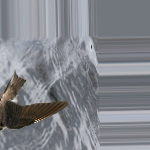


Transformation number: 3



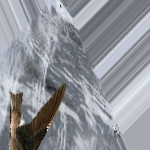

In [ ]:
# An ImageDataGenerator with more extreme data augmentation
sample_gen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=90,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.5,
        zoom_range=0.5,
        vertical_flip=True,
        horizontal_flip=True)

display_transformations(sample_gen)

In [ ]:
# Load pretrained model & history

augmented_history = pd.read_csv('history-augmented/history-augmented.csv')
augmented_model = tf.keras.models.load_model('model-augmented')

In [ ]:
# Run only if you want to train model yourself (this takes around 20 mins with GPU enabled)

# augmented_history = augmented_model.fit(
#     train_generator,
#     steps_per_epoch=100,
#     epochs=80,
#     validation_data=validation_generator,
#     validation_steps=80)

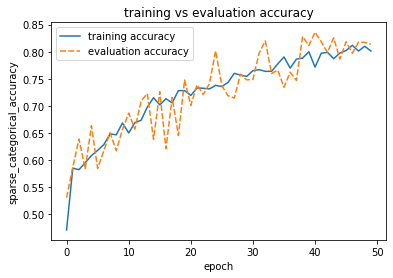

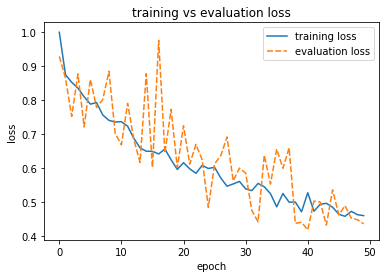

In [ ]:
plot_train_eval(augmented_history)

Now, evaluation accuracy follows more closely training one. **Model is no longer overfitting**, achieved by just augmenting data set. 

Another option to handle overfitting is to include dropout layers in your model as mentioned earlier.

This model achieves a slightly lower evaluation accuracy when compared to model without data augmentation. Because it needs more epochs to train. To spot this issue, check that for model without data augmentation, training accuracy reached almost 100%, whereas augmented one can still improve.
